<a href="https://colab.research.google.com/github/Vnykm/GN22CDBDS001_2113702/blob/main/ARIMA__Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [9]:
!wget https://github.com/a-forty-two/COG_GN22CDBDS001_MARCH_22/blob/main/LifeUniverseAndEverything.xlsx?raw=true

--2022-03-31 04:32:13--  https://github.com/a-forty-two/COG_GN22CDBDS001_MARCH_22/blob/main/LifeUniverseAndEverything.xlsx?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/a-forty-two/COG_GN22CDBDS001_MARCH_22/raw/main/LifeUniverseAndEverything.xlsx [following]
--2022-03-31 04:32:13--  https://github.com/a-forty-two/COG_GN22CDBDS001_MARCH_22/raw/main/LifeUniverseAndEverything.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/a-forty-two/COG_GN22CDBDS001_MARCH_22/main/LifeUniverseAndEverything.xlsx [following]
--2022-03-31 04:32:13--  https://raw.githubusercontent.com/a-forty-two/COG_GN22CDBDS001_MARCH_22/main/LifeUniverseAndEverything.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.1

In [10]:
!cp LifeUniverseAndEverything.xlsx?raw=true LifeUniverseAndEverything.xlsx

In [11]:
exclfile = 'LifeUniverseAndEverything.xlsx'
data = pd.read_excel(exclfile)
data

,Life,O2,O3,H2O,N2,H2,Sunlight,Aliens,Plants
0,5,6,38,48,25,38,0,1,1
1,4,0,4,2,6,13,0,1,0
2,4,11,3,78,30,15,0,0,1
3,0,22,30,68,28,23,0,1,0
4,10,20,23,56,20,27,1,0,1
...,...,...,...,...,...,...,...,...,...
195,10,24,0,90,24,26,0,1,1
196,10,21,6,75,34,4,0,0,0
197,0,13,8,42,18,2,0,0,1
198,0,4,38,2,21,4,1,0,1


In [32]:
data.isnull().values.any()

False

In [16]:
df_life = data
X = df_life.drop('Life', axis=1)
y = df_life['Life']

In [29]:
X.shape

(200, 8)

In [30]:
y.shape

(200,)

In [13]:
numeric_var = ['O2', 'O3', 'H2O', 'N2', 'H2']
categorical_var = ['Sunlight','Aliens','Plants']

In [14]:
from sklearn.pipeline import Pipeline #sklearn==0.23.2
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier

tuples = list()

tuples.append((Pipeline([
        ('scaler', StandardScaler()),
    ]), numeric_var))

tuples.append((Pipeline([
        ('onehot', OneHotEncoder()),
    ]), categorical_var))

preprocess = make_column_transformer(*tuples)

pipe = Pipeline([
    ('preprocess', preprocess),
    ('classifier', LGBMClassifier())
])

In [17]:
#GRID SEARCH
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": [0.0001, 0.0005, 0.001, 0.01, 0.1],
    "classifier__n_estimators": [100, 300, 600, 800, 1000],
    "classifier__max_depth": [ 4, 20, 100, 250, 400] 
}

# grid
reg_grid = GridSearchCV(pipe,
                        param_grid=param_grid,
                        cv=5,
                        n_jobs=8, 
                        scoring='roc_auc'
                       )

model_grid = reg_grid.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


In [18]:
#random search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

n_iter = 70

param_grid = {
    "classifier__learning_rate": loguniform(1e-4, 0.1),
    "classifier__n_estimators": randint(100,1000),
    "classifier__max_depth": randint(4, 400) 
}

# Random
reg_rand = RandomizedSearchCV(pipe,
                         param_distributions=param_grid,
                         n_iter=n_iter,
                         cv=5,
                         n_jobs=8,
                         scoring='roc_auc',
                         random_state=123)

model_rand = reg_rand.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


In [36]:
from skopt import BayesSearchCV

# Bayesian
n_iter = 70

param_grid = {
    "classifier__learning_rate": (0.0001, 0.1, "log-uniform"),
    "classifier__n_estimators": (100,  1000) ,
    "classifier__max_depth": (4, 400) 
}

reg_bay = BayesSearchCV(estimator=pipe,
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=5,
                    n_jobs=8,
                    random_state=123)

model_bay = reg_bay.fit(X, y)

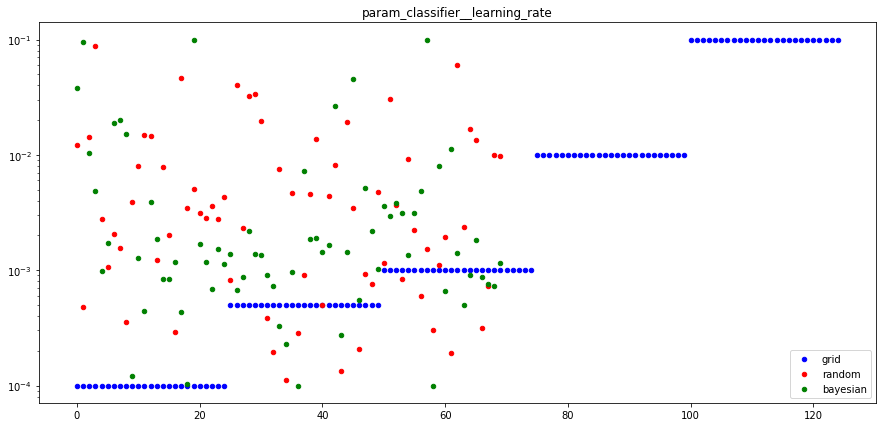

In [37]:

param = 'param_classifier__learning_rate'

grid = model_grid.cv_results_[param]
rand = model_rand.cv_results_[param]
bay = model_bay.cv_results_[param]

fig = plt.figure(figsize=(15, 7))

ax = plt.gca()
ax.scatter(np.arange(len(grid)), grid.data, c='b', s=20, label='grid');
ax.scatter(np.arange(len(rand)), rand.data, c='r', s=20, label='random');
ax.scatter(np.arange(len(bay)), bay, c='g', s=20, label='bayesian');
ax.set_yscale('log')

plt.legend();
plt.title(param);